In [1]:
import cv2
import json
import numpy as np
import pandas as pd
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

In [2]:
class_colormap = pd.read_csv("/opt/ml/segmentation/baseline_code/class_dict.csv")
color_map_array = class_colormap.iloc[:, 1:].values.astype(np.uint8)

category_names = ["Backgroud", "General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

coco = COCO('/opt/ml/segmentation/input/data/train_all.json')

imgIds = coco.getImgIds()

# annImgDir = '/opt/ml/segmentation/input/ann_data'

loading annotations into memory...
Done (t=4.61s)
creating index...
index created!


In [4]:
def merge_image(insert_image, insert_mask, class_id, base_image=None, base_mask=None):
    """
    Args:
        insert_image: 
        insert_mask:
        class_id:
        base_image:
        base_mask:
    """
    tmp_img = np.ones((512,512,3), dtype=np.uint8) * 255
    if type(base_image) is type(None):
        base_image = tmp_img.copy()
    tmp_img[:,:,0] = np.where(insert_mask == class_id, insert_image[:,:,0], base_image[:,:,0])  # R
    tmp_img[:,:,1] = np.where(insert_mask == class_id, insert_image[:,:,1], base_image[:,:,1])  # G
    tmp_img[:,:,2] = np.where(insert_mask == class_id, insert_image[:,:,2], base_image[:,:,2])  # B
    if type(base_mask) is type(None):
        base_mask = np.zeros((512,512), dtype=np.uint8)
    tmp_mask = np.where(insert_mask == class_id, insert_mask, base_mask)  # mask
    return tmp_img, tmp_mask

In [3]:
masks = []
imgNames = []

for imgId in tqdm(imgIds):
    imgInfo = coco.loadImgs(imgId)[0]

    annIds = coco.getAnnIds(imgIds=imgInfo['id'])
    anns = coco.loadAnns(annIds)

    mask = np.zeros((imgInfo["height"], imgInfo["width"]), dtype=np.uint8)

    anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=True)
    for ann in anns:
        annCatId = ann['category_id']
        assert annCatId != 0, 'category_id must be not 0.'
        mask[coco.annToMask(ann) == 1] = annCatId

    if np.any(np.isin([1, 2, 8, 6], mask)):
        imgNames.append(imgInfo['file_name'])
        masks.append(mask)
    
    # mask_list.append(list(np.unique(mask)))
    # mask_list.update(np.unique(mask))
    # _file_name = f"{annImgDir}/{imgInfo['file_name']}"
    # _parent_path = Path(_file_name).parent
    # if not _parent_path.exists():
    #     _parent_path.mkdir(parents=True)

    # # plt.imsave(_file_name, color_map_array[mask]) # rgb
    # plt.imsave(_file_name, mask)
    # plt.imsave('test_mask.jpg', mask)
    # plt.imsave('test_mask.png', mask)

100%|██████████| 3272/3272 [00:31<00:00, 102.57it/s]


In [13]:
extractImgPath = '/opt/ml/segmentation/extract_image/'

In [45]:
cat1ImgNames = [_.stem for _ in Path(f"{extractImgPath}1/image").iterdir()]
cat4ImgNames = [_.stem for _ in Path(f"{extractImgPath}4/image").iterdir()]
cat5ImgNames = [_.stem for _ in Path(f"{extractImgPath}5/image").iterdir()]
cat6ImgNames = [_.stem for _ in Path(f"{extractImgPath}6/image").iterdir()]
cat10ImgNames = [_.stem for _ in Path(f"{extractImgPath}10/image").iterdir()]

In [55]:
print(f"cat1ImgNames: {cat1ImgNames.__len__()}")
print(f"cat4ImgNames: {cat4ImgNames.__len__()}")
print(f"cat5ImgNames: {cat5ImgNames.__len__()}")
print(f"cat6ImgNames: {cat6ImgNames.__len__()}")
print(f"cat10ImgNames: {cat10ImgNames.__len__()}")

cat1ImgNames: 107
cat4ImgNames: 65
cat5ImgNames: 78
cat6ImgNames: 202
cat10ImgNames: 39


In [16]:
ImgDir = '/opt/ml/segmentation/input/data/'

In [72]:
rnd_idx = np.random.permutation([_ for _ in range(len(masks))])
rnd_list = rnd_idx.tolist()

index를 섞은 후에 pop을 통해 하나 씩 뽑아 사용합니다. 이것을 통해 중복된 이미지에 들어가지 않도록 하였습니다.

In [77]:
targetCatId = 10

targetImgNames = eval(f"cat{targetCatId}ImgNames")
extractImgPath = '/opt/ml/segmentation/extract_image/'
mergeImgPath = '/opt/ml/segmentation/merge_image/'

cnt = 0

save_dir = f"{mergeImgPath}"
Path(f"{save_dir}/image/").mkdir(exist_ok=True, parents=True)
Path(f"{save_dir}/mask/").mkdir(exist_ok=True, parents=True)

for _ in range(10):  # 해당 category에 대해 반복을 몇번 할지 정합니다.
    j = 0
    for idx in tqdm(range(len(targetImgNames))):
        cnt += 1

        _file_name = targetImgNames[idx]
        if _file_name.startswith('image'):
            cnt -= 1
            continue
        image1 = cv2.imread(f"{extractImgPath}{targetCatId}/image/{_file_name}.png")
        mask1 = cv2.imread(f"{extractImgPath}{targetCatId}/mask/{_file_name}.png", cv2.IMREAD_GRAYSCALE)

        rnd_idx = rnd_list.pop()
        base_image = cv2.imread(f"{ImgDir}{imgNames[rnd_idx]}")
        base_mask = masks[rnd_idx]
        # try:
        tmp_img, tmp_mask = merge_image(image1, mask1, targetCatId, base_image, base_mask)
        cv2.imwrite(f"{save_dir}/image/synth{targetCatId}_{cnt:04d}.png", tmp_img)
        cv2.imwrite(f"{save_dir}/mask/synth{targetCatId}_{cnt:04d}.png", tmp_mask.astype(np.uint8))
        j += 1
        # except:
        #     pass
        # fig, axes = plt.subplots(2, 2, figsize=(6, 6), dpi=150)
        # axes[0, 0].imshow(image1)
        # axes[0, 0].axis("off")
        # axes[0, 1].imshow(mask1)
        # axes[0, 1].axis("off")
        # axes[1, 0].imshow(tmp_img)
        # axes[1, 0].axis("off")
        # axes[1, 1].imshow(tmp_mask)
        # axes[1, 1].axis("off")
    print(j)

  8%|▊         | 3/39 [00:00<00:01, 27.03it/s]

39


  8%|▊         | 3/39 [00:00<00:01, 26.78it/s]

39


  8%|▊         | 3/39 [00:00<00:01, 26.59it/s]

39


  8%|▊         | 3/39 [00:00<00:01, 26.51it/s]

39


  8%|▊         | 3/39 [00:00<00:01, 27.76it/s]

39


  8%|▊         | 3/39 [00:00<00:01, 26.49it/s]

39


  8%|▊         | 3/39 [00:00<00:01, 26.67it/s]

39


  8%|▊         | 3/39 [00:00<00:01, 26.16it/s]

39


  8%|▊         | 3/39 [00:00<00:01, 26.48it/s]

39


100%|██████████| 39/39 [00:01<00:00, 26.35it/s]

39


In [61]:
targetImgNames[idx]

'batch_02_vt_1114_0'

In [23]:
from collections import Counter

In [28]:
catFreq = Counter()
for _mask in masks:
    catFreq.update(np.unique(_mask))

In [29]:
catFreq

Counter({0: 3272,
         5: 202,
         6: 1140,
         8: 1863,
         1: 1405,
         4: 322,
         2: 1760,
         3: 416,
         7: 539,
         10: 114,
         9: 19})

(-0.5, 511.5, 511.5, -0.5)

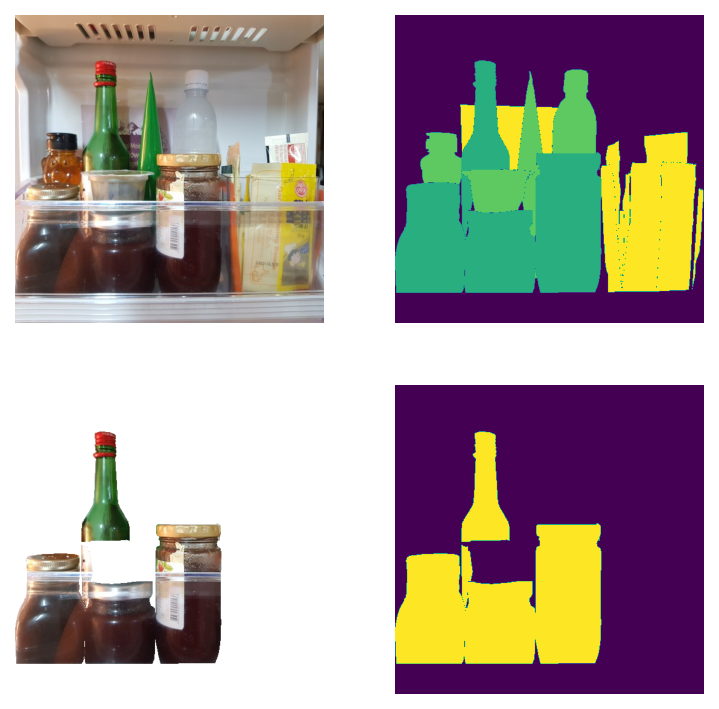

In [115]:
tmp_img, tmp_mask = merge_image(image1, mask1, 5)
fig, axes = plt.subplots(2, 2, figsize=(6, 6), dpi=150)
axes[0, 0].imshow(image1)
axes[0, 0].axis("off")
axes[0, 1].imshow(mask1)
axes[0, 1].axis("off")
axes[1, 0].imshow(tmp_img)
axes[1, 0].axis("off")
axes[1, 1].imshow(tmp_mask)
axes[1, 1].axis("off")

(-0.5, 511.5, 511.5, -0.5)

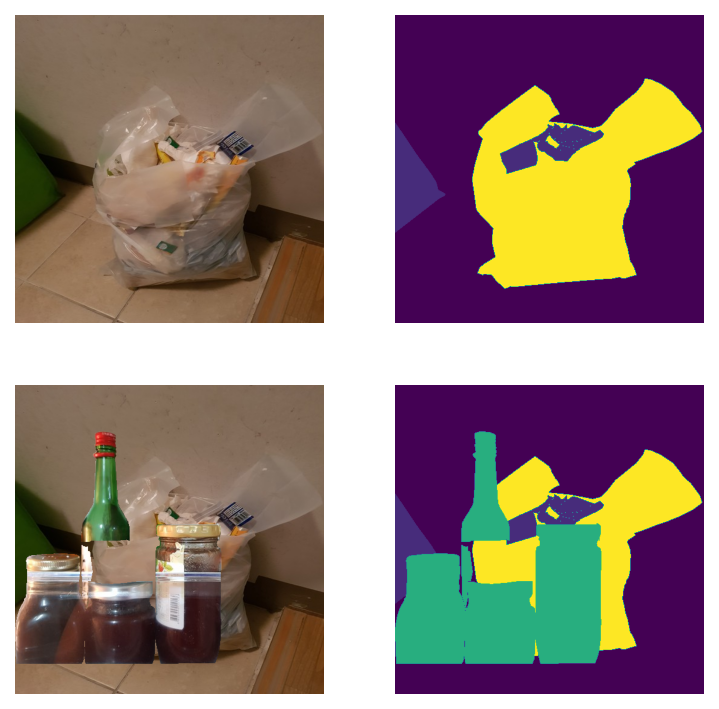

In [116]:
tmp_img, tmp_mask = merge_image(image1, mask1, 5, base_image=image2, base_mask=mask2)
fig, axes = plt.subplots(2, 2, figsize=(6, 6), dpi=150)
axes[0, 0].imshow(image2)
axes[0, 0].axis("off")
axes[0, 1].imshow(mask2)
axes[0, 1].axis("off")
axes[1, 0].imshow(tmp_img)
axes[1, 0].axis("off")
axes[1, 1].imshow(tmp_mask)
axes[1, 1].axis("off")

In [154]:
train_json = "/opt/ml/segmentation/input/data/train.json"
val_json = "/opt/ml/segmentation/input/data/val.json"

with open(val_json) as f:
    val_json = json.load(f)

with open(train_json) as f:
    train_json = json.load(f)

In [155]:
val_df = pd.DataFrame(val_json['images'])
train_df = pd.DataFrame(train_json['images'])

In [163]:
val_df

,license,url,file_name,height,width,date_captured,id
0,0,None,batch_01_vt/0002.jpg,512,512,None,0
1,0,None,batch_01_vt/0009.jpg,512,512,None,1
2,0,None,batch_01_vt/0018.jpg,512,512,None,2
3,0,None,batch_01_vt/0019.jpg,512,512,None,3
4,0,None,batch_01_vt/0030.jpg,512,512,None,4
...,...,...,...,...,...,...,...
650,0,None,batch_03/0981.jpg,512,512,None,650
651,0,None,batch_03/0982.jpg,512,512,None,651
652,0,None,batch_03/0988.jpg,512,512,None,652
653,0,None,batch_03/0993.jpg,512,512,None,653
